# PIL.Image to array

In [5]:
# PIL.Image.open('image.jpg')###show image

# I = numpy.asarray(PIL.Image.open('image.jpg'))

In [6]:
import _pickle as cPickle
import numpy as np
from scipy.stats import spearmanr, scoreatpercentile
from scipy.sparse.linalg import svds
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import time
%pylab inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matrix_completion import svt_solve, calc_unobserved_rmse
import PIL
from skimage import color
from skimage import io

Populating the interactive namespace from numpy and matplotlib


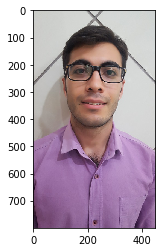

In [7]:
# load image

Image = mpimg.imread('Image.jpg')
plt.imshow(Image)
Height, Width = Image.shape[0], Image.shape[1]

(800, 450)


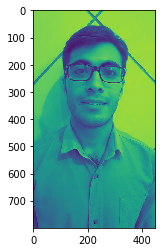

In [8]:
# rgb to gray

Gray_Image = color.rgb2gray(io.imread('Image.jpg'))
print(Gray_Image.shape)
plt.imshow(Gray_Image)

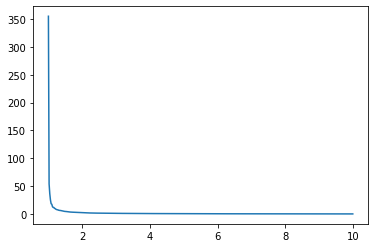

In [9]:
u, s, vh = np.linalg.svd(Gray_Image, full_matrices=True)
x = np.linspace(1,10,450)

plt.plot(x,s)

# save gray image ??????????????????????????

In [10]:
def pepper_salt_noise(p,image):
    m, n = image.shape
    frac = 1- p
    sample = np.random.binomial(1, frac, size=m*n)
    mask = np.reshape(sample, (m, n))
    image_noise = image * mask
    return mask, image_noise

# create different rate noised images

In [11]:
mask = []
image_noise = []
img = Gray_Image

p = [0.1, 0.5, 0.9]
for i in p:
    pepper_salt_noise(i, Gray_Image)
    mask.append(pepper_salt_noise(i, img)[0])
    image_noise.append(pepper_salt_noise(i, img)[1])
    

In [12]:
def similarity(im1, im2):
    centeredA = im1 - np.mean(im1, axis=(0,1))
    centeredB = im2 - np.mean(im2, axis=(0,1))
    sum_pix = lambda arr: np.sum(arr, axis=(0, 1))

    values = sum_pix((centeredA) * (centeredB)) / np.sqrt(sum_pix(np.power(centeredA, 2)) * sum_pix(np.power(centeredB, 2)))
    return np.mean(values)

In [13]:
initial_err = []
for i in range(len(image_noise)):
    initial_err.append(similarity(img, image_noise[i]))

# initial_errors

In [14]:
# from numpy import linalg as LA
# initial_errors = []
# for i in range(len(image_noise)):
#     err = Gray_Image - image_noise[i]
#     initial_errors.append(err)
#     ###norm 

In [15]:
# initial_frob_norms = [] 
# for i in range(len(initial_errors)):
#     norm = LA.norm(initial_errors[i], 'fro') / LA.norm(img, 'fro')
#     initial_frob_norms.append(norm)

# plot noisy images

/home/rahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


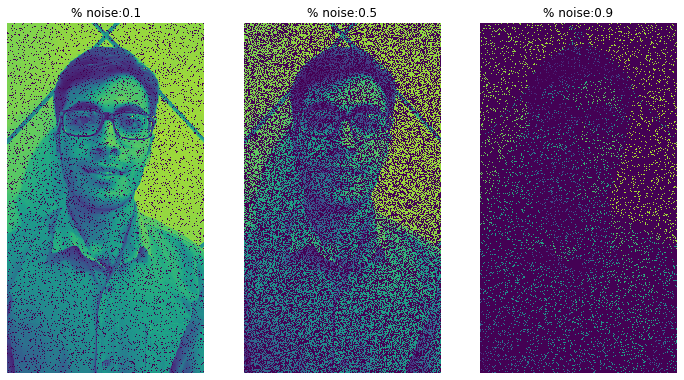

In [16]:
fig = plt.figure(figsize=(12, 8))
columns = 3
rows = 1

ax = []
for i in range(0, len(image_noise)):
    img = image_noise[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("% noise:"+str(p[i]))  # set title
    fig.add_subplot(rows, columns, i+1).set_axis_off()
    plt.imshow(img)


plt.show()

# SVT

In [17]:
### SVT feature extraction

# https://github.com/BeautyOfWeb/ModuleDiscovery-SVT/blob/master/sol_dream11.py

def svt_feature(mat, M = None, include_diagonal = False, svd_k = 50, svd_maxiter = 100, svt_delta = 1.5, e=0.0001, svt_maxiter=100, save_feature=False, feature_filename=''):    
    if M is None or include_diagonal:
        idx1 = np.where(mat!=0)[0]
        idx2 = np.where(mat!=0)[1]
        M = mat[idx1, idx2]
    else:
        idx1 = np.array(M[:,0], dtype='int')
        idx2 = np.array(M[:,1], dtype='int')
        M = M[:,2]
    tic = time.time()
    # Efficient svd implementation from scipy
    U,s,V = svds(mat, k = svd_k, maxiter = svd_maxiter)
    loop = 0
    i = 0
    err = 100    # Initial error set a large number
    # First svd approximation
    Y = U.dot(np.diag(s)).dot(V)
    while err > e and i <= svt_maxiter:
        Y[idx1, idx2] += svt_delta * (M - Y[idx1, idx2])
        U,s,V = svds(Y, k = svd_k, maxiter=svd_maxiter)
        Y = U.dot(np.diag(s)).dot(V)
        i += 1
        err = np.sum((M - Y[idx1, idx2])**2) / np.sum(M**2)
        print('iteration:', i, ' relative error:', err)
        if i % 10 == 0:
            c = np.corrcoef(U.dot(np.diag(np.sqrt(s))))
            print('correlation:', np.corrcoef(c[idx1, idx2], M)[0,1])
    print('SVT time:', time.time()-tic)
    print('Top ', svd_k, ' singlar values:', np.sqrt(s))
    X = U.dot(np.diag(np.sqrt(s)))
    if save_feature:
        pickle.dump(X, open(feature_filename, 'wb'), -1)    
    return X,Y

# recover gray images

In [18]:
sigma = []
denoised_images = []
for i in range(len(image_noise)):
    Sigma, Denoised_Image = svt_feature(image_noise[i])
    sigma.append(Sigma)
    denoised_images.append(Denoised_Image)

iteration: 1  relative error: 0.006234643146949349
iteration: 2  relative error: 0.0025270449024348256
iteration: 3  relative error: 0.0017824093801555249
iteration: 4  relative error: 0.001546528279527514
iteration: 5  relative error: 0.0015137852253947358
iteration: 6  relative error: 0.00145968687302111
iteration: 7  relative error: 0.001471822567207009
iteration: 8  relative error: 0.001447175743478709
iteration: 9  relative error: 0.0014679241976135507
iteration: 10  relative error: 0.0014500659561963688
correlation: 0.317072915817107
iteration: 11  relative error: 0.0014682723377174695
iteration: 12  relative error: 0.0014529315264321038
iteration: 13  relative error: 0.0014685578925251687
iteration: 14  relative error: 0.0014550525849692801
iteration: 15  relative error: 0.0014687239378924917
iteration: 16  relative error: 0.0014567079106422437
iteration: 17  relative error: 0.0014688906999443699
iteration: 18  relative error: 0.0014580873154084423
iteration: 19  relative error:

iteration: 36  relative error: 0.0015655590790328204
iteration: 37  relative error: 0.0015409563869838898
iteration: 38  relative error: 0.0015175661822086428
iteration: 39  relative error: 0.0014953091120050474
iteration: 40  relative error: 0.0014741176495404924
correlation: 0.2788569485475979
iteration: 41  relative error: 0.001453933350219782
iteration: 42  relative error: 0.0014347034587247312
iteration: 43  relative error: 0.001416377586168832
iteration: 44  relative error: 0.0013989054049883608
iteration: 45  relative error: 0.0013822359648723453
iteration: 46  relative error: 0.0013663185593751318
iteration: 47  relative error: 0.0013511044956915188
iteration: 48  relative error: 0.0013365489354815769
iteration: 49  relative error: 0.0013226121882271894
iteration: 50  relative error: 0.001309260231424557
correlation: 0.29578275025562795
iteration: 51  relative error: 0.0012964645466995049
iteration: 52  relative error: 0.001284201472746487
iteration: 53  relative error: 0.00127

iteration: 70  relative error: 0.0002665156279905926
correlation: -0.049297372235679024
iteration: 71  relative error: 0.0002560354868665481
iteration: 72  relative error: 0.00024604506707501906
iteration: 73  relative error: 0.00023651725673801876
iteration: 74  relative error: 0.00022742670524468752
iteration: 75  relative error: 0.00021874969072065013
iteration: 76  relative error: 0.0002104639988913148
iteration: 77  relative error: 0.00020254881223447574
iteration: 78  relative error: 0.00019498460843689935
iteration: 79  relative error: 0.00018775306727467604
iteration: 80  relative error: 0.00018083698512989243
correlation: -0.045481114380799534
iteration: 81  relative error: 0.00017422019643815553
iteration: 82  relative error: 0.00016788750143411225
iteration: 83  relative error: 0.00016182459962643572
iteration: 84  relative error: 0.00015601802849091355
iteration: 85  relative error: 0.0001504551069210861
iteration: 86  relative error: 0.00014512388302111414
iteration: 87  r

# plot recovered images(SVT)

/home/rahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


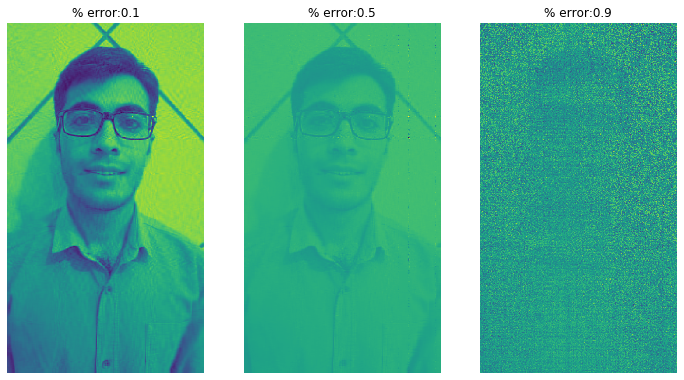

In [19]:
fig = plt.figure(figsize=(12, 8))
columns = 3
rows = 1

ax = []

for i in range(0, len(denoised_images)):
    img = denoised_images[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("% error:"+str(p[i]))  # set title
    fig.add_subplot(rows, columns, i+1).set_axis_off()

    plt.imshow(img)


plt.show()

In [20]:
# # denoised_images

# recovered_frob_norms = [] 
# for i in range(len(denoised_images)):
#     norm = LA.norm(denoised_images[i], 'fro') / LA.norm(img, 'fro')
#     recovered_frob_norms.append(norm)

In [21]:
# recovered_frob_norms

In [22]:
denoised_err = []
for i in range(len(denoised_images)):
    denoised_err.append(similarity(img, denoised_images[i]))

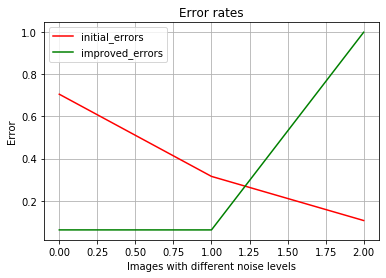

In [23]:
plt.plot(initial_err, 'r', label='initial_errors') 
plt.plot(denoised_err,'g', label='improved_errors')
plt.ylabel('Error')
plt.xlabel('Images with different noise levels')
plt.title('Error rates')


# plt.plot(t, c, 'g') # plotting t, c separately 
plt.legend()
plt.grid()
plt.show()

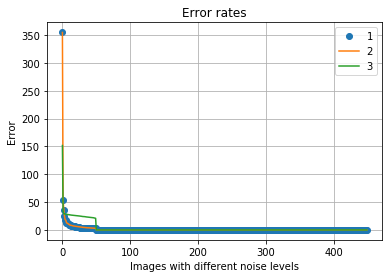

In [24]:
S = []
for i in range(len(denoised_images)):
    u, s, vh = np.linalg.svd(denoised_images[i], full_matrices=True)
    x = np.linspace(1,10,450)
    S.append(s)

plt.plot(S[0],"o" ,label='1') 
plt.plot(S[1], label='2') 
plt.plot(S[2], label='3') 

plt.ylabel('Error')
plt.xlabel('Images with different noise levels')
plt.title('Error rates')


plt.legend()
plt.grid()
plt.show()